## Logistic Regression in Spark MLLIB

Reference: http://github.com/DeltaOptimist/Logistic_regression_BDA_Classification_Pyspark/blob/main/Logistics.ipynb

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ml-diabetes").getOrCreate()

df = spark.read.csv("diabetes.csv", header = True, inferSchema = True)
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)




The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

Input variables: Glucose,BloodPressure,BMI,Age,Pregnancies,Insulin,SkinThikness,DiabetesPedigreeFunction.

Output variables: Outcome.

In [ ]:
import pandas as pd
pd.DataFrame(df.take(5), columns = df.columns).transpose()

,0,1,2,3,4
Pregnancies,6.000,1.000,8.000,1.000,0.000
Glucose,148.000,85.000,183.000,89.000,137.000
BloodPressure,72.000,66.000,64.000,66.000,40.000
SkinThickness,35.000,29.000,0.000,23.000,35.000
Insulin,0.000,0.000,0.000,94.000,168.000
BMI,33.600,26.600,23.300,28.100,43.100
DiabetesPedigreeFunction,0.627,0.351,0.672,0.167,2.288
Age,50.000,31.000,32.000,21.000,33.000
Outcome,1.000,0.000,1.000,0.000,1.000


In [ ]:
df.show()

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
|          5|    116|           74|            0|      0|25.6|                   0.201| 30|      0|
|          3|     78|           50|           32|     88|31.0|                   0.248| 26|      1|


In [ ]:
df.toPandas()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
df.groupby('Outcome').count().toPandas()

,Outcome,count
0,1,268
1,0,500


In [ ]:
#Obtaining the numerical features
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
numeric_features

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'Age',
 'Outcome']

In [ ]:
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Pregnancies,768,3.8450520833333335,3.36957806269887,0,17
Glucose,768,120.89453125,31.97261819513622,0,199
BloodPressure,768,69.10546875,19.355807170644777,0,122
SkinThickness,768,20.536458333333332,15.952217567727642,0,99
Insulin,768,79.79947916666667,115.24400235133803,0,846
Age,768,33.240885416666664,11.760231540678689,21,81
Outcome,768,0.3489583333333333,0.476951377242799,0,1


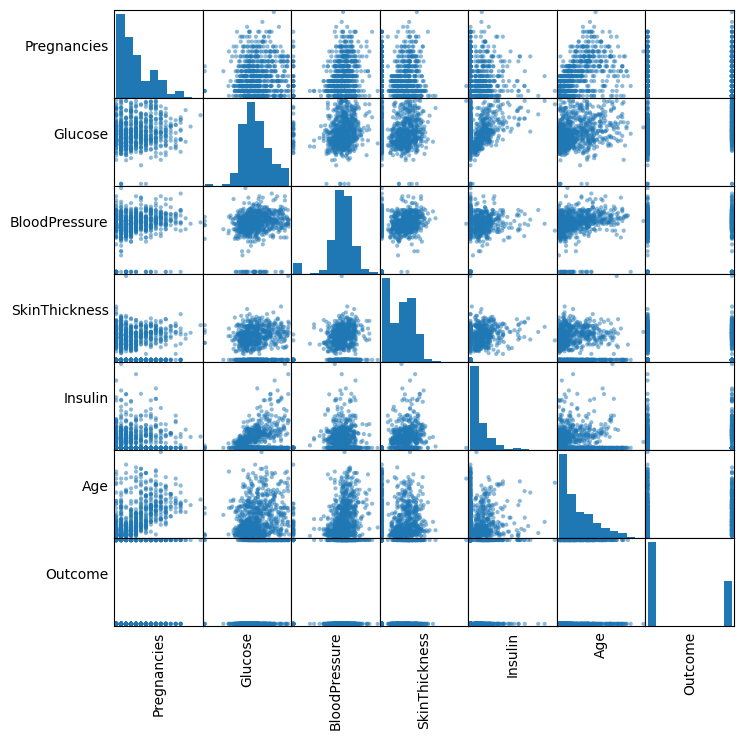

In [ ]:
#Plotting the scatter plot of each numeric feature with the others.
from pandas.plotting import scatter_matrix
numeric_data = df.select(numeric_features).toPandas()

axs = scatter_matrix(numeric_data, figsize = (8,8))

n=len(numeric_data.columns)
for i in range(n):
  v = axs[i,0]
  v.yaxis.label.set_rotation(0)
  v.yaxis.label.set_ha('right')
  v.set_yticks(())
  h = axs[n-1, i]
  h.xaxis.label.set_rotation(90)
  h.set_xticks(())

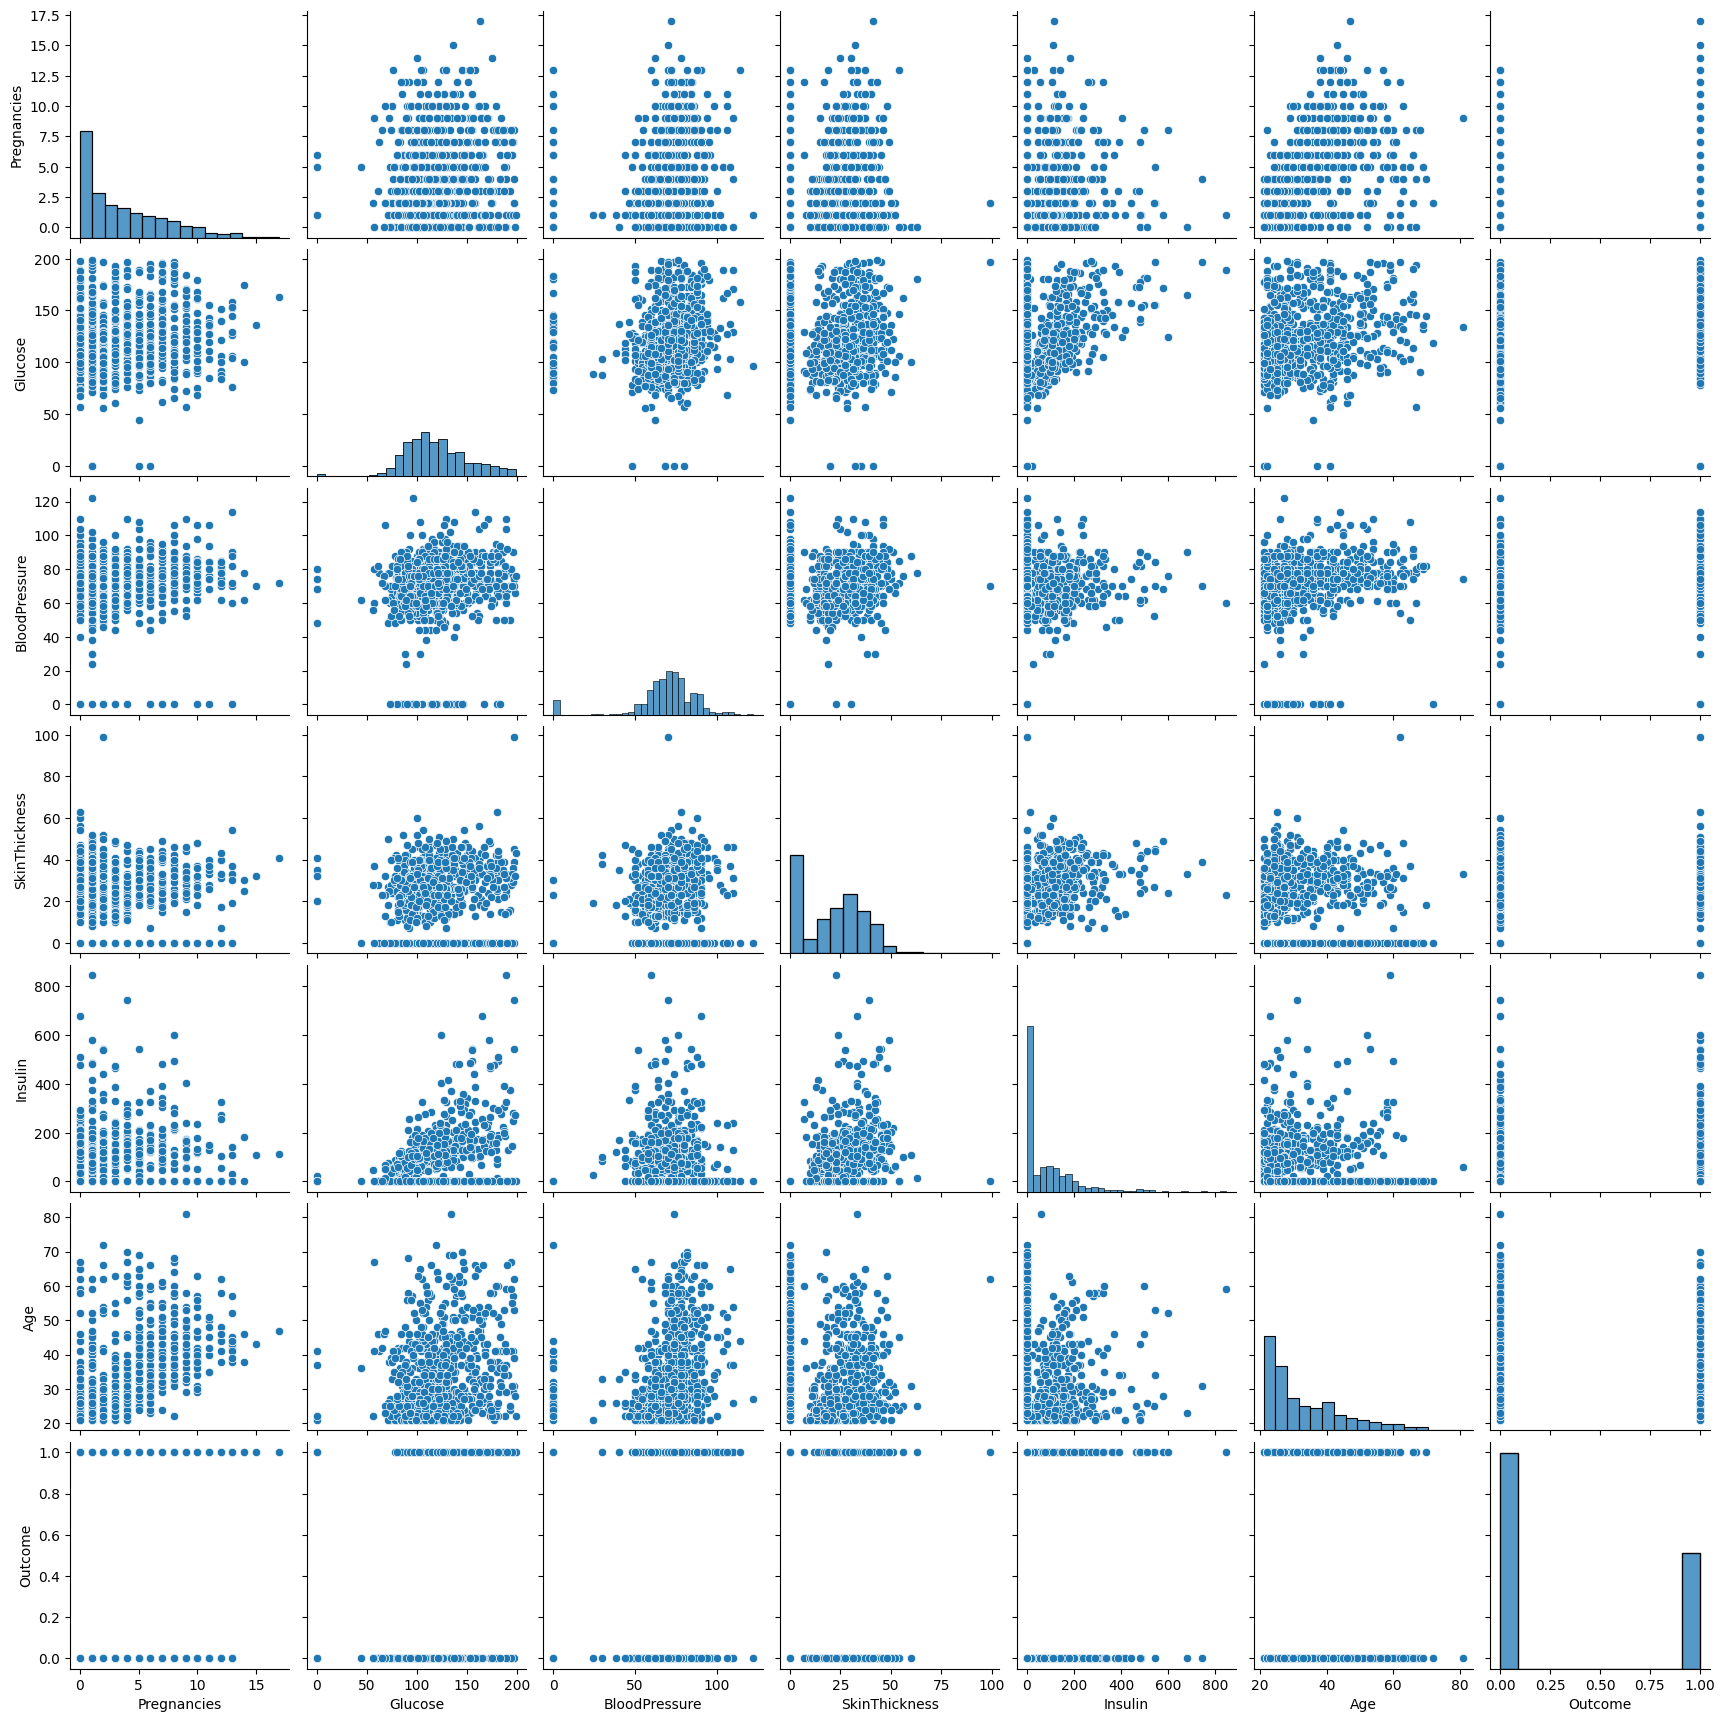

In [ ]:
#Plotting the same as above with seaborn
import seaborn as sns
numeric_data = df.select(numeric_features).toPandas()
sns.pairplot(numeric_data)
import matplotlib.pyplot as plt
plt.show()

In [ ]:
#Missing data handling
from pyspark.sql.functions import isnull, when, count, col
df.select([count(when(isnull(c),c)).alias(c) for c in df.columns]).show()

+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin|BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+
|          0|      0|            0|            0|      0|  0|                       0|  0|      0|
+-----------+-------+-------------+-------------+-------+---+------------------------+---+-------+



In [ ]:
df.toPandas().isna().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [ ]:
#Dropping irrelevant columns
dataset_final = df.drop("SkinThickness").drop("Insulin").drop("DiabetesPedigreeFunction").drop("Pregnancies")
dataset_final.show()

+-------+-------------+----+---+-------+
|Glucose|BloodPressure| BMI|Age|Outcome|
+-------+-------------+----+---+-------+
|    148|           72|33.6| 50|      1|
|     85|           66|26.6| 31|      0|
|    183|           64|23.3| 32|      1|
|     89|           66|28.1| 21|      0|
|    137|           40|43.1| 33|      1|
|    116|           74|25.6| 30|      0|
|     78|           50|31.0| 26|      1|
|    115|            0|35.3| 29|      0|
|    197|           70|30.5| 53|      1|
|    125|           96| 0.0| 54|      1|
|    110|           92|37.6| 30|      0|
|    168|           74|38.0| 34|      1|
|    139|           80|27.1| 57|      0|
|    189|           60|30.1| 59|      1|
|    166|           72|25.8| 51|      1|
|    100|            0|30.0| 32|      1|
|    118|           84|45.8| 31|      1|
|    107|           74|29.6| 31|      1|
|    103|           30|43.3| 33|      0|
|    115|           70|34.6| 32|      1|
+-------+-------------+----+---+-------+
only showing top

In [ ]:
#Converting features to a vector using VectorAssembler
required_features = ['Glucose','BloodPressure','BMI','Age']

from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols = required_features, outputCol="features")
transformed_data = assembler.transform(dataset_final)
transformed_data.show()

+-------+-------------+----+---+-------+--------------------+
|Glucose|BloodPressure| BMI|Age|Outcome|            features|
+-------+-------------+----+---+-------+--------------------+
|    148|           72|33.6| 50|      1|[148.0,72.0,33.6,...|
|     85|           66|26.6| 31|      0|[85.0,66.0,26.6,3...|
|    183|           64|23.3| 32|      1|[183.0,64.0,23.3,...|
|     89|           66|28.1| 21|      0|[89.0,66.0,28.1,2...|
|    137|           40|43.1| 33|      1|[137.0,40.0,43.1,...|
|    116|           74|25.6| 30|      0|[116.0,74.0,25.6,...|
|     78|           50|31.0| 26|      1|[78.0,50.0,31.0,2...|
|    115|            0|35.3| 29|      0|[115.0,0.0,35.3,2...|
|    197|           70|30.5| 53|      1|[197.0,70.0,30.5,...|
|    125|           96| 0.0| 54|      1|[125.0,96.0,0.0,5...|
|    110|           92|37.6| 30|      0|[110.0,92.0,37.6,...|
|    168|           74|38.0| 34|      1|[168.0,74.0,38.0,...|
|    139|           80|27.1| 57|      0|[139.0,80.0,27.1,...|
|    189

In [ ]:
# Split the data
(training_data, test_data) = transformed_data.randomSplit([0.8,0.2], seed =2020)

print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 620
Test Dataset Count: 148


**Logistic Regression Model**

Logistic regression is the appropriate regression analysis to conduct when the dependent variable is dichotomous (binary).

Like all regression analyses, the logistic regression is a predictive analysis.

Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.

Logistic Regression is used when the dependent variable(target) is categorical.

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'Outcome', maxIter=10)
lrModel = lr.fit(training_data)
lr_predictions = lrModel.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'Outcome', metricName = 'accuracy')
print('Logistic Regression Accuracy:', multi_evaluator.evaluate(lr_predictions))

Logistic Regression Accuracy: 0.777027027027027
